Text(0, 0.5, 'Assembled sequence scanned (Mbp)')

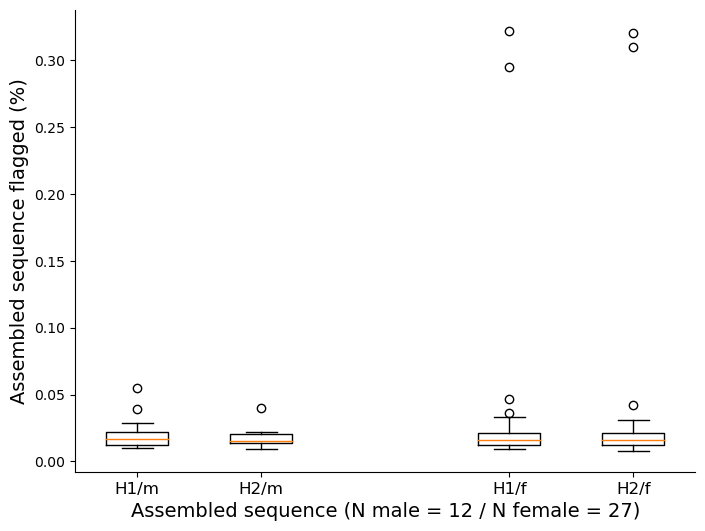

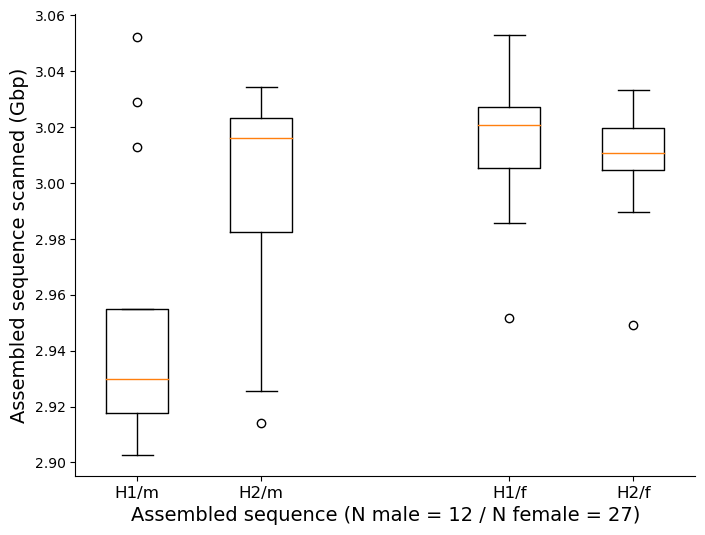

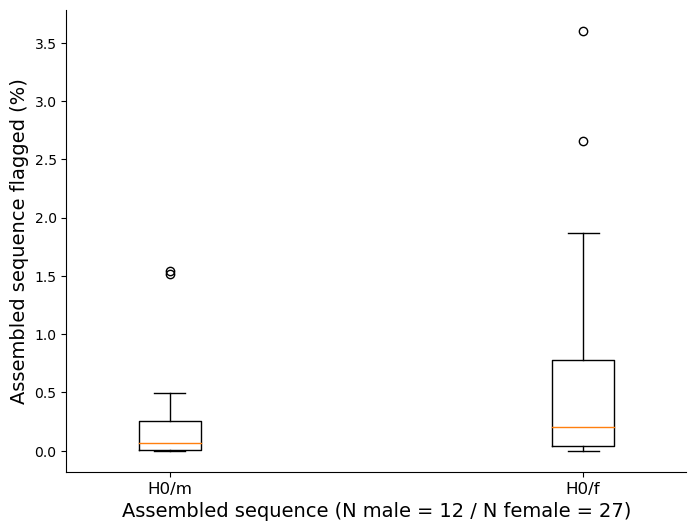

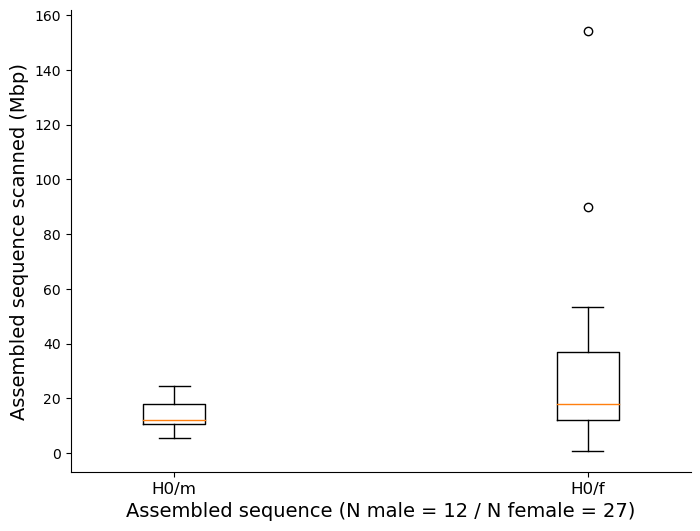

In [46]:
%run "../../../00_project_config.ipynb"

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

nf_data_folder = PROJECT_DATA_ROOT.joinpath(
    "2023_nucfreq"
)

nf_stats = []
for hdf_file in nf_data_folder.glob("*.hdf"):
    with pd.HDFStore(hdf_file, "r") as hdf:
        sample = hdf_file.name.split(".")[0]
        stats_table = hdf["group_table"]
        stats_table["asm_unit"] = stats_table["contig"].apply(lambda x: x.rsplit(".", 1)[-1])
        stats_table["nz_length"] = stats_table["end"] - stats_table["start"]
        stats_table = stats_table.loc[stats_table["asm_unit"].isin(["hap1", "hap2", "unassigned", "disconnected"]), :].copy()
        
        sample_stats = stats_table.groupby("asm_unit").agg(
            total_length=("length", "sum"),
            covered_length=("nz_length", "sum"),
            discordant_pos=("num_discordant_pos", "sum"),
            flagged_regions=("num_flagged_regions", "sum"),
            flagged_bp=("flagged_bp", 'sum')
        )
        sample_stats.reset_index(drop=False, inplace=True)
        sample_stats["sample"] = sample
        sample_stats["pct_flagged"] = (sample_stats["flagged_bp"] / sample_stats["covered_length"] * 100).round(3)
        nf_stats.append(sample_stats)
        
nf_stats = pd.concat(nf_stats, axis=0, ignore_index=False)
nf_stats.reset_index(drop=True, inplace=True)

sample_sex = dict((row.sample, row.sex) for row in HGSVC_SAMPLES.itertuples())

nf_stats["sex"] = nf_stats["sample"].replace(sample_sex)

male_subset = nf_stats.loc[nf_stats["sex"] == "male", :].copy()
female_subset = nf_stats.loc[nf_stats["sex"] == "female", :].copy()

fig, ax = plt.subplots(figsize=(8,6))

boxes = ax.boxplot(
    [
        male_subset.loc[male_subset["asm_unit"] == "hap1", "pct_flagged"],
        male_subset.loc[male_subset["asm_unit"] == "hap2", "pct_flagged"],
        female_subset.loc[female_subset["asm_unit"] == "hap1", "pct_flagged"],
        female_subset.loc[female_subset["asm_unit"] == "hap2", "pct_flagged"],
    ],
    positions=[1,2,4,5]
)
ax.set_xticks([1,2,4,5])
ax.set_xticklabels(["H1/m", "H2/m", "H1/f", "H2/f"], fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Assembled sequence (N male = 12 / N female = 27)", fontsize=14)
ax.set_ylabel("Assembled sequence flagged (%)", fontsize=14)

fig, ax = plt.subplots(figsize=(8,6))

boxes = ax.boxplot(
    [
        male_subset.loc[male_subset["asm_unit"] == "hap1", "covered_length"].values/1e9,
        male_subset.loc[male_subset["asm_unit"] == "hap2", "covered_length"].values/1e9,
        female_subset.loc[female_subset["asm_unit"] == "hap1", "covered_length"].values/1e9,
        female_subset.loc[female_subset["asm_unit"] == "hap2", "covered_length"].values/1e9,
    ],
    positions=[1,2,4,5]
)
ax.set_xticks([1,2,4,5])
ax.set_xticklabels(["H1/m", "H2/m", "H1/f", "H2/f"], fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Assembled sequence (N male = 12 / N female = 27)", fontsize=14)
ax.set_ylabel("Assembled sequence scanned (Gbp)", fontsize=14)

### unassigned sequence

fig, ax = plt.subplots(figsize=(8,6))

boxes = ax.boxplot(
    [
        male_subset.loc[male_subset["asm_unit"] == "unassigned", "pct_flagged"],
        female_subset.loc[female_subset["asm_unit"] == "unassigned", "pct_flagged"],
    ],
    positions=[1,3]
)
ax.set_xticks([1,3])
ax.set_xticklabels(["H0/m", "H0/f"], fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Assembled sequence (N male = 12 / N female = 27)", fontsize=14)
ax.set_ylabel("Assembled sequence flagged (%)", fontsize=14)


fig, ax = plt.subplots(figsize=(8,6))

boxes = ax.boxplot(
    [
        male_subset.loc[male_subset["asm_unit"] == "unassigned", "covered_length"].values/1e6,
        female_subset.loc[female_subset["asm_unit"] == "unassigned", "covered_length"].values/1e6,
    ],
    positions=[1,3]
)
ax.set_xticks([1,3])
ax.set_xticklabels(["H0/m", "H0/f",], fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Assembled sequence (N male = 12 / N female = 27)", fontsize=14)
ax.set_ylabel("Assembled sequence scanned (Mbp)", fontsize=14)